### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):
    
    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([1, 2, 7, 6, 5, 4]),
 array([[3, 2],
        [1, 7],
        [2, 6],
        [7, 5],
        [6, 4],
        [5, 0]]))

In [3]:
# transform contexts and targets to one-hot encoding
### <your code> ###
contexts = convert_one_hot(contexts,len(word2idx))
targets = convert_one_hot(targets,len(word2idx))
contexts, targets

(array([[0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int32),
 array([[[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]]], dtype=int32))

In [4]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size * 2)]#輸出層的loss function
        

        layers = [self.in_layer,self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size * 2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size * 2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [5]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(len(word2idx), hidden_size, window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 28%|██▊       | 277/1000 [00:00<00:00, 1148.86it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.159102253895648
Epoch: 2, Iteration: 1/2, Loss: 4.159074430211167
Epoch: 3, Iteration: 1/2, Loss: 4.158833529037984
Epoch: 4, Iteration: 1/2, Loss: 4.158909165956155
Epoch: 5, Iteration: 1/2, Loss: 4.158838097029035
Epoch: 6, Iteration: 1/2, Loss: 4.158701381338954
Epoch: 7, Iteration: 1/2, Loss: 4.158700042452905
Epoch: 8, Iteration: 1/2, Loss: 4.158596408621332
Epoch: 9, Iteration: 1/2, Loss: 4.1585512591544
Epoch: 10, Iteration: 1/2, Loss: 4.1583702454655
Epoch: 11, Iteration: 1/2, Loss: 4.158286799808709
Epoch: 12, Iteration: 1/2, Loss: 4.15851634985325
Epoch: 13, Iteration: 1/2, Loss: 4.158245197119749
Epoch: 14, Iteration: 1/2, Loss: 4.158001782434594
Epoch: 15, Iteration: 1/2, Loss: 4.158006358166824
Epoch: 16, Iteration: 1/2, Loss: 4.157830977691435
Epoch: 17, Iteration: 1/2, Loss: 4.157709165229592
Epoch: 18, Iteration: 1/2, Loss: 4.157885114736914
Epoch: 19, Iteration: 1/2, Loss: 4.157242406620566
Epoch: 20, Iteration: 1/2, Loss: 4.1571798589

 63%|██████▎   | 631/1000 [00:00<00:00, 1399.95it/s]

Epoch: 284, Iteration: 1/2, Loss: 1.4151334188910298
Epoch: 285, Iteration: 1/2, Loss: 1.4164962506527023
Epoch: 286, Iteration: 1/2, Loss: 1.4155313423681055
Epoch: 287, Iteration: 1/2, Loss: 1.4144842375075493
Epoch: 288, Iteration: 1/2, Loss: 1.4150989440536292
Epoch: 289, Iteration: 1/2, Loss: 1.4155558346004324
Epoch: 290, Iteration: 1/2, Loss: 1.4146441538776615
Epoch: 291, Iteration: 1/2, Loss: 1.4165293232873082
Epoch: 292, Iteration: 1/2, Loss: 1.414130384872006
Epoch: 293, Iteration: 1/2, Loss: 1.4112399545780063
Epoch: 294, Iteration: 1/2, Loss: 1.413819204366422
Epoch: 295, Iteration: 1/2, Loss: 1.4116628030328133
Epoch: 296, Iteration: 1/2, Loss: 1.4160683985054896
Epoch: 297, Iteration: 1/2, Loss: 1.4133149059846382
Epoch: 298, Iteration: 1/2, Loss: 1.4142941840015169
Epoch: 299, Iteration: 1/2, Loss: 1.408904034041663
Epoch: 300, Iteration: 1/2, Loss: 1.4134040389788165
Epoch: 301, Iteration: 1/2, Loss: 1.4163907480009872
Epoch: 302, Iteration: 1/2, Loss: 1.4096610776315

100%|██████████| 1000/1000 [00:00<00:00, 1653.06it/s]

Epoch: 638, Iteration: 1/2, Loss: 1.3928165955778067
Epoch: 639, Iteration: 1/2, Loss: 1.3942182543988615
Epoch: 640, Iteration: 1/2, Loss: 1.3932802841448781
Epoch: 641, Iteration: 1/2, Loss: 1.392770733919729
Epoch: 642, Iteration: 1/2, Loss: 1.3932312890538645
Epoch: 643, Iteration: 1/2, Loss: 1.3932785437958115
Epoch: 644, Iteration: 1/2, Loss: 1.3936274910785085
Epoch: 645, Iteration: 1/2, Loss: 1.392892340182624
Epoch: 646, Iteration: 1/2, Loss: 1.3926962106708096
Epoch: 647, Iteration: 1/2, Loss: 1.3933591102075285
Epoch: 648, Iteration: 1/2, Loss: 1.3934894025495634
Epoch: 649, Iteration: 1/2, Loss: 1.3926521594982433
Epoch: 650, Iteration: 1/2, Loss: 1.3935718668008037
Epoch: 651, Iteration: 1/2, Loss: 1.39323044386198
Epoch: 652, Iteration: 1/2, Loss: 1.392554189469341
Epoch: 653, Iteration: 1/2, Loss: 1.3936333622154988
Epoch: 654, Iteration: 1/2, Loss: 1.3929121595626799
Epoch: 655, Iteration: 1/2, Loss: 1.3932281001299303
Epoch: 656, Iteration: 1/2, Loss: 1.392912323280406

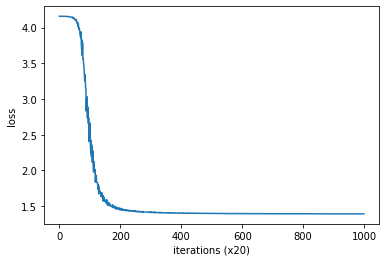

In [6]:
trainer.plot()

In [7]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

. [-0.02104972  0.0160558   0.01488748 -0.00902945 -0.01703968]
am [-2.1066048  -0.18309624 -0.58661705 -1.7736628   0.33806205]
studying [ 1.2546953  -1.6356769   1.5718917  -1.2123983   0.36087835]
i [-0.00874478 -0.00774224  0.00751108 -0.0028715   0.00498274]
now [-0.6636539   0.21635652 -0.37370643  2.0742426  -1.7138873 ]
processing [1.4679385  1.8523949  0.03081351 0.7691914  1.3991402 ]
language [ 0.6481037  -2.3686128   0.61162436  1.3291777  -1.1303934 ]
natural [-0.24834062  2.0332856  -1.9307452  -1.139497    0.7099215 ]
